# Inspecting Partial Prediction Samples

## Parameters

In [1]:
ALIGNMENT_SEQUENCE = "baseline"
TEMPORAL_ALIGNMENT_TOLERANCE = 0.1
ALIGNMENT_WORD_NORMALIZATION = True

## Setup

In [2]:
import sys
sys.path.append("..")

from src.eval.SampleResult import SampleResult
from src.eval.utils.draw_alignments import draw

In [3]:
RESULTS_05_05 = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"
RESULTS_05_02 = "../out/2025-05-02_10-50-33_librispeech-pc-test-clean_large-v3-turbo"

In [4]:
def load_single_sample(result_dir, sample_id):
    s = SampleResult.load_by_id(result_dir, sample_id)
    s.build_alignments(
        normalize_words=ALIGNMENT_WORD_NORMALIZATION,
        align_to=ALIGNMENT_SEQUENCE,
        temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE,
    )
    return s

## Results

### Impossible content window timing

As can be seen in the following example, there were many instances where the content window of the prediction exceeds the observation time (52, 57, 65), which is impossible due to contraints of reality. So most likely, the system outputs wrong timestamps for these partial prediction.

After inspecting these samples, this behaviour can be observed around final messages. This was due to the asynchronous nature of the examined ASR system. When producing a final message the internal clock was shifted to the new position of the content window. This happend before the system has fully proccessed the last partial prediction, so the new shifted clock was used to label the previous prediction leading to the overall shifted timings.

This was fixed in the ASR system, by preserving the clock that was used when the prediction has started and introducing some execution order in the computation of the final messages.

/Users/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:158: UserWarning: Final MFA file not found: ../out/2025-05-02_10-50-33_librispeech-pc-test-clean_large-v3-turbo/mfa/5639-40744-0000/5639-40744-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")


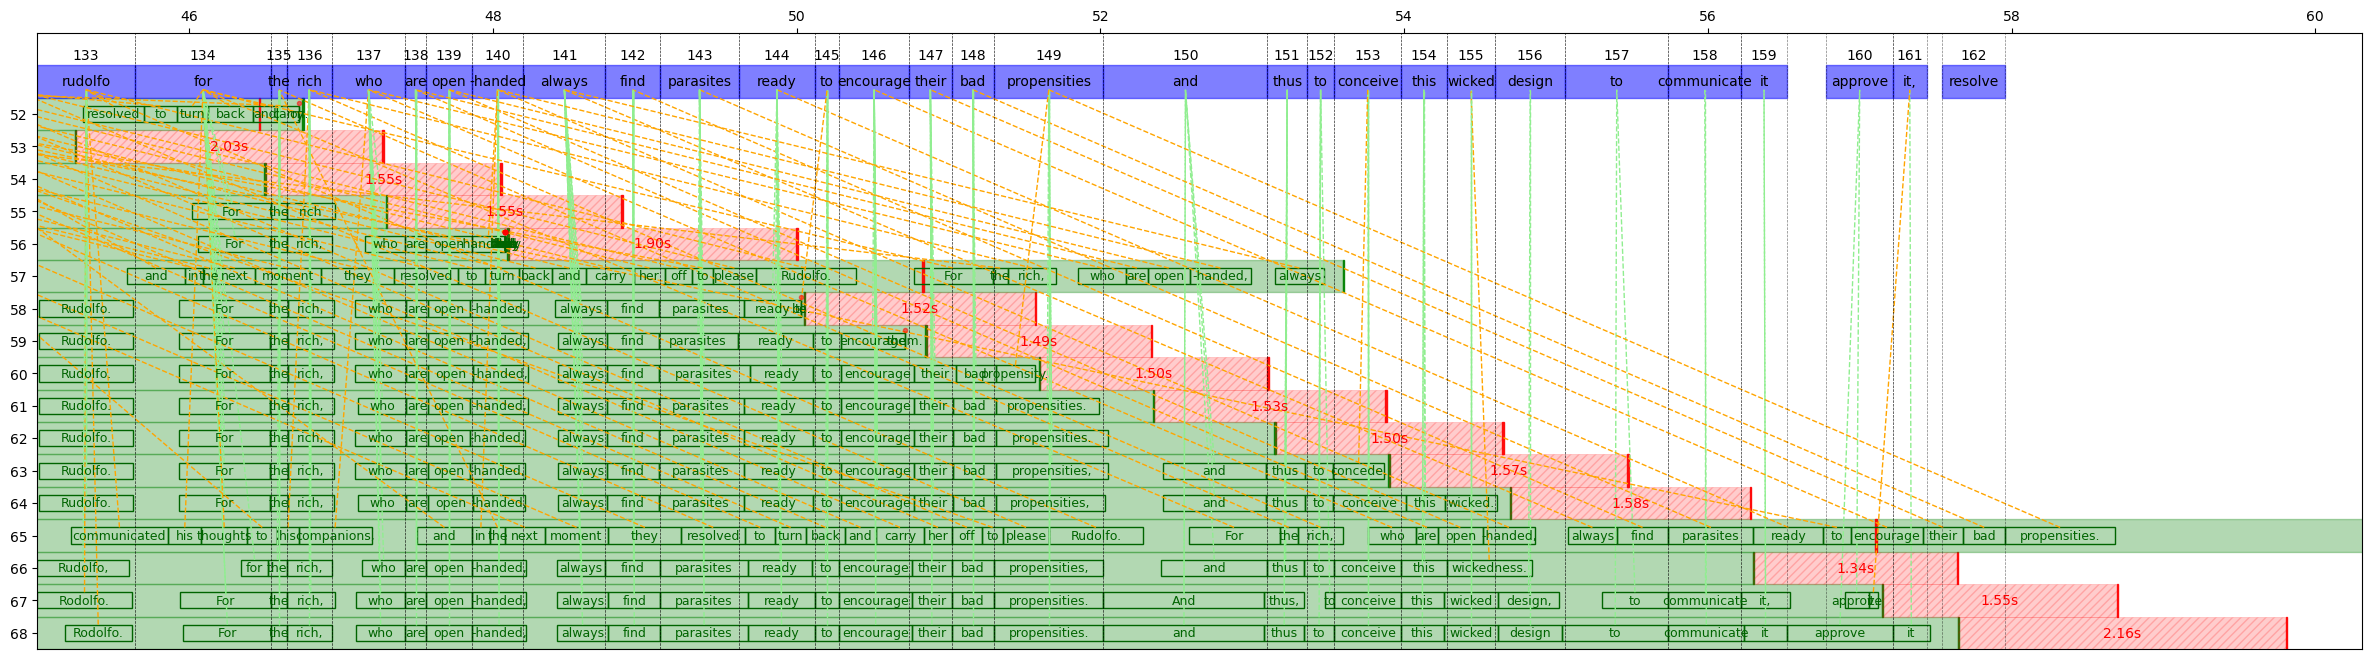

In [5]:
sample = load_single_sample(RESULTS_05_02, "5639-40744-0000")
draw(sample, 133, 30)

### Ever growing window size

In this example we can see that starting from prediction 68 the observation delay between the end of the content window and the observation time increases and there are no predicted words in the visible frame. This indicates, that the prediction was not performed as expected.

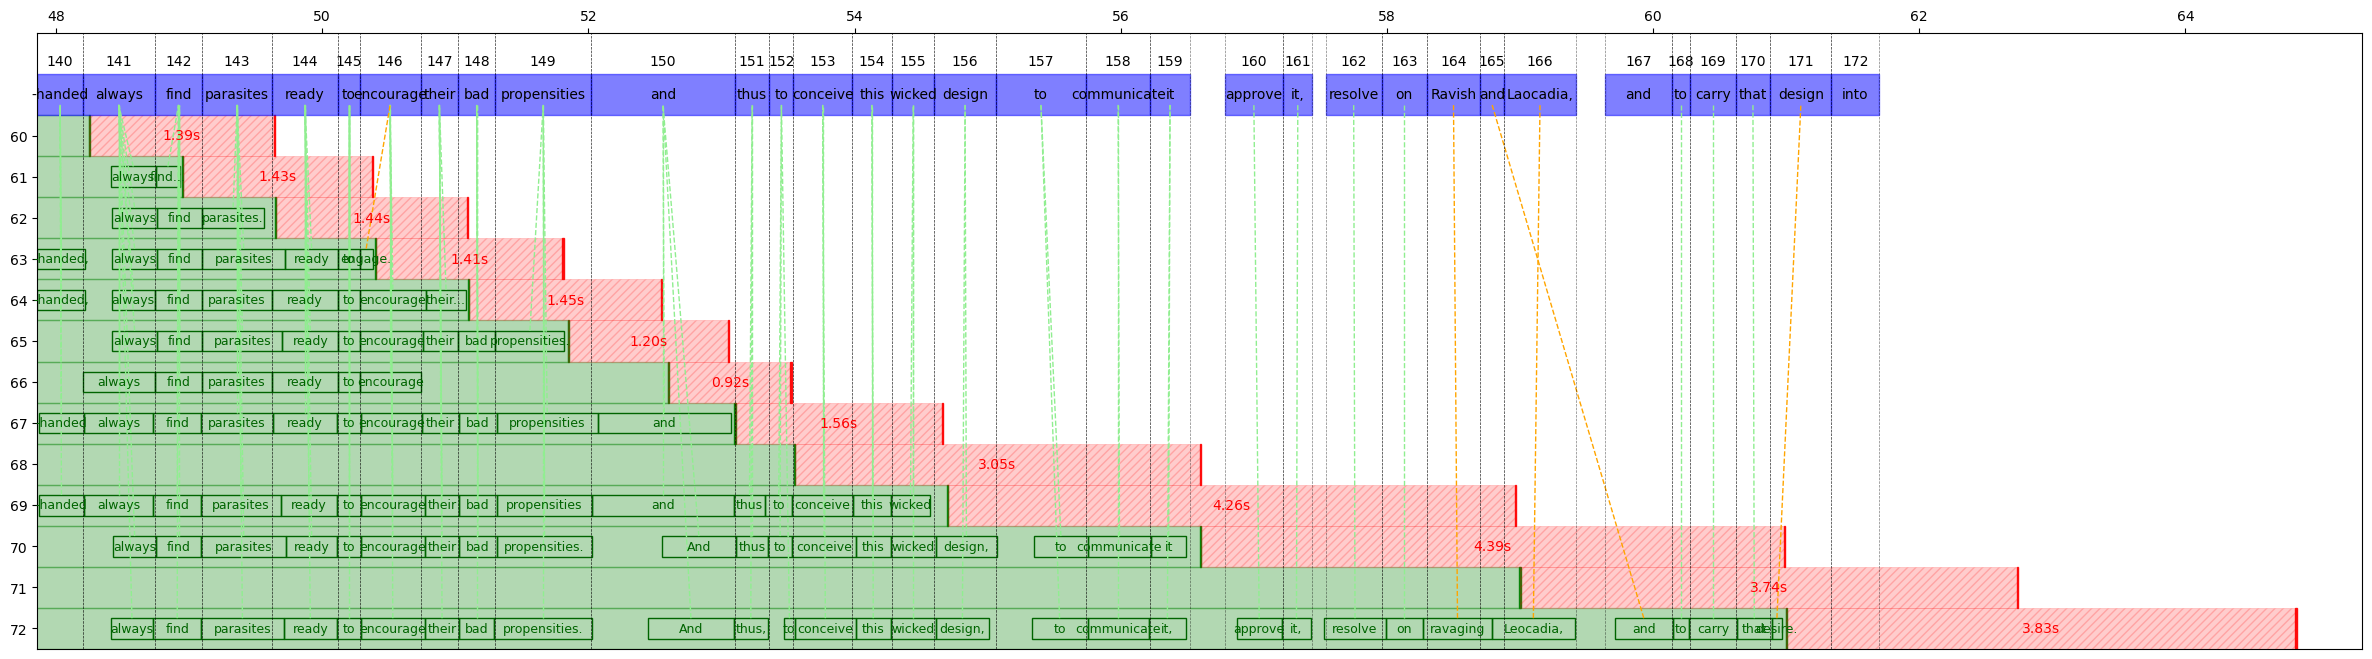

In [6]:
sample = load_single_sample(RESULTS_05_05, "5639-40744-0000")
draw(sample, 140, 33)

The partial prediction 68 also contains multiple overlapping words towards the start of the content window.

In [7]:
for w in sample.partials[68].result:
    print(f"{w.start:.2f} - {w.end:.2f}: {w.word}")

38.05 - 38.31: nd
38.31 - 38.31: in
38.31 - 38.31: the
38.31 - 38.31: next
38.31 - 38.31: moment
38.31 - 38.55: he
38.55 - 39.19: communicated
39.19 - 39.43: his
39.43 - 39.73: thoughts
39.73 - 39.93: to
39.93 - 40.07: his
40.07 - 40.53: companions,
40.87 - 41.21: and
41.21 - 41.33: in
41.33 - 41.43: the
41.43 - 41.69: next
41.69 - 42.47: they
42.47 - 43.01: resolved
43.01 - 43.19: to
43.19 - 43.41: turn
43.41 - 43.63: back
43.63 - 43.87: and
43.87 - 44.17: carry
44.17 - 44.37: her
44.37 - 44.55: off
44.55 - 44.71: to
44.71 - 44.99: please.


Starting from that point, the content window used for partial prediction starts growing, without being capped for roughly 130 seconds. 

In [8]:
for i in range(63, 112):
    p = sample.partials[i]
    print(f"Prediction {i:3d} for time window {p.window} with length {p.window[1] - p.window[0]:.2f}s")

Prediction  63 for time window (34.6, 50.4) with length 15.80s
Prediction  64 for time window (34.6, 51.1) with length 16.50s
Prediction  65 for time window (36.8, 51.85) with length 15.05s
Prediction  66 for time window (36.8, 52.6) with length 15.80s
Prediction  67 for time window (38.05, 53.1) with length 15.05s
Prediction  68 for time window (38.05, 53.55) with length 15.50s
Prediction  69 for time window (38.05, 54.7) with length 16.65s
Prediction  70 for time window (38.05, 56.6) with length 18.55s
Prediction  71 for time window (38.05, 59.0) with length 20.95s
Prediction  72 for time window (38.05, 61.0) with length 22.95s
Prediction  73 for time window (38.05, 62.75) with length 24.70s
Prediction  74 for time window (38.05, 64.85) with length 26.80s
Prediction  75 for time window (38.05, 66.9) with length 28.85s
Prediction  76 for time window (38.05, 69.35) with length 31.30s
Prediction  77 for time window (38.05, 71.9) with length 33.85s
Prediction  78 for time window (38.05, 